# Google Play Store apps and reviews

 Мобильные приложения есть везде. Их легко создавать и они могут быть прибыльными. Из-за этих двух факторов разрабатывается все больше и больше приложений. В этом блокноте мы проведем всесторонний анализ рынка приложений для Android, сравнив более десяти тысяч приложений в Google Play в разных категориях. Мы будем искать информацию в данных, чтобы разработать стратегии для стимулирования роста и удержания.

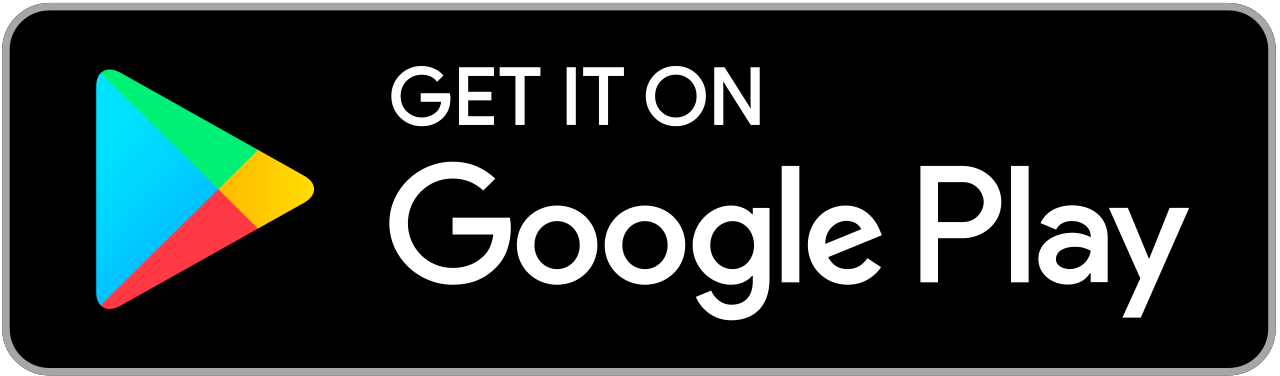

#### Давайте взглянем на данные, которые состоят из двух файлов:

* Файл apps.csv: содержит все сведения о приложениях в Google Play. Существует 13 переменных, описывающих данное приложение.
* user_reviews.csv: содержит 100 отзывов для каждого приложения, наиболее полезных в первую очередь. Текст в каждом обзоре был предварительно обработан и дополнен тремя новыми переменными: Настрой (Положительный, Отрицательный или Нейтральный), Полярность настроений и Субъективность настроений.

In [93]:
# библиотеки
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objs as go
import seaborn as sns
import warnings
import matplotlib.pyplot as plt


In [22]:
# Посмотрим как выглядят данные

apps_raw = pd.read_csv(r'C:/Users/roald/Desktop/datasets/googleplaystore.csv')

print('--------------- Первые 5 строк -----------------')
print(apps_raw.head(5))
print('')
print('-------------- Общая информация ----------------')
print(apps_raw.info())
print('')
print('------------- Кол-во дубликатов ----------------')
print(apps_raw.duplicated().sum())

--------------- Первые 5 строк -----------------
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 201

Видим, что в некоторых переменных есть пропуски значений. Также, в датасете есть дубликаты. 

## Очистка данных

Просматривая случайную выборку строк набора данных (из приведенной выше задачи), мы замечаем, что некоторые записи в столбцах, такие как Установки и Цена, содержат несколько специальных символов (+ , $) из-за способа представления чисел. Это не позволяет столбцам быть чисто числовыми, что затрудняет их использование в последующих будущих математических расчетах. В идеале, как следует из их названий, мы хотели бы, чтобы эти столбцы содержали только цифры из [0-9].

In [25]:
# Удалим дубликаты
apps = apps_raw.drop_duplicates()

In [37]:
# Удалим сомнительные строки
apps = apps[apps['Installs'] != 'Free']

In [28]:
# Список знаков к удалению
chars_to_remove = ['+',',','$']

# Список столбцов для очистки
cols_to_clean = ['Installs','Price']

# Цикл для очистки столбцов
for col in cols_to_clean:
    # цикл для очистки переменных
    for char in chars_to_remove:
        # замена пропусками
        apps[col] = apps[col].apply(lambda x: x.replace(char, ''))

<ipython-input-28-2adea0160548>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apps[col] = apps[col].apply(lambda x: x.replace(char, ''))


## Исправление типов данных

Из предыдущей задачи мы заметили, что установки и цена были классифицированы как тип данных object, а не int или float. Это связано с тем, что эти два столбца изначально имели смешанные типы ввода: цифры и специальные символы.

Четыре переменные, которые мы исправим - это установки, размер, рейтинг и цена. 

In [40]:
# Конвертируем установки в тип float
apps['Installs'] = apps['Installs'].astype(float)

# Конвертируем цену в тип float
apps['Price'] = apps['Price'].astype(float)

# Проверка типов данных
print(apps.dtypes)

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs          float64
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


<ipython-input-40-f8906f5c8b28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apps['Installs'] = apps['Installs'].astype(float)
<ipython-input-40-f8906f5c8b28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apps['Price'] = apps['Price'].astype(float)


## Изучение категорий приложений

С более чем 1 миллиардом активных пользователей в 190 странах мира Google Play продолжает оставаться важной платформой распространения для создания глобальной аудитории. Чтобы компании могли показывать свои приложения пользователям, важно сделать их более быстрыми и легко доступными в Google Play. Чтобы улучшить общее качество поиска, Google внедрила концепцию группировки приложений по категориям.

Это подводит нас к следующим вопросам:

* В какой категории самая высокая доля (активных) приложений на рынке?
* Доминирует ли на рынке какая-либо конкретная категория?
* В каких категориях меньше всего приложений?

In [58]:
# Число уникальных категорий 
num_categories = apps.Category.nunique()
print('Число категорий = ', num_categories)

# Число приложений в категориях
num_apps_in_category = apps['Category'].value_counts(sort=True)


data = [go.Bar(
        x = num_apps_in_category.index, # index = category name
        y = num_apps_in_category.values, # value = count
)]

plotly.offline.iplot(data)

Число категорий =  33


Мы видим, что в нашем наборе данных присутствует 33 уникальных категории приложений. Семейные и игровые приложения имеют самую высокую распространенность на рынке. Интересно, что инструменты, бизнес-и медицинские приложения также находятся на первых местах.

## Распределение рейтингов приложений

Ознакомившись с долей рынка для каждой категории приложений, давайте посмотрим, как все эти приложения работают в среднем. Рейтинги приложений (по шкале от 1 до 5) влияют на доступность, конверсию приложений, а также на общий имидж. Рейтинги являются ключевым показателем эффективности приложения.

In [61]:
# Средний рейтинг приложений
avg_app_rating = apps.Rating.mean()
print('Средний рейтинг приложений = ', avg_app_rating)

# Распредление приложений по рейтингу
data = [go.Histogram(
        x = apps['Rating']
)]

# Вертикальный дашборд
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_app_rating,
              'y0': 0,
              'x1': avg_app_rating,
              'y1': 1000,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Средний рейтинг приложений =  4.187876743139908


В результате нашего исследования мы обнаружили, что средний объем оценок по всем категориям приложений составляет 4,17. График гистограммы смещен влево, что указывает на то, что большинство приложений имеют высокий рейтинг, за исключением нескольких приложений с низким рейтингом.

## Размер и цена приложения

Давайте теперь рассмотрим размер приложения и его цену. Что касается размера, то, если мобильное приложение слишком велико, его загрузка может быть сложной и/или дорогостоящей для пользователей. Длительное время загрузки может отключить пользователей еще до того, как они получат доступ к вашему мобильному приложению. Кроме того, устройство каждого пользователя имеет ограниченный объем дискового пространства. По цене некоторые пользователи ожидают, что их приложения будут бесплатными или недорогими. Эти проблемы усугубляются, если развивающийся мир является частью вашего целевого рынка; особенно из-за скорости Интернета, возможностей для заработка и обменных курсов.

Как мы можем эффективно разрабатывать стратегии для определения размера и цены нашего приложения?

Влияет ли размер приложения на его рейтинг?
Действительно ли пользователи заботятся о приложениях с большой нагрузкой на систему или они предпочитают легкие приложения?
Влияет ли цена приложения на его рейтинг?
Всегда ли пользователи предпочитают бесплатные приложения платным приложениям?
Мы обнаружили, что большинство приложений с самым высоким рейтингом (рейтинг более 4) колеблются от 2 МБ до 20 МБ. Мы также обнаружили, что подавляющее большинство приложений оценивают себя ниже 10 долларов.

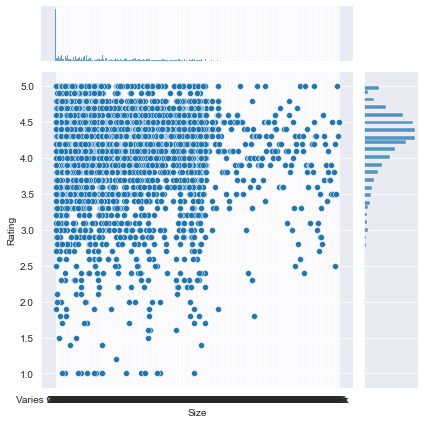

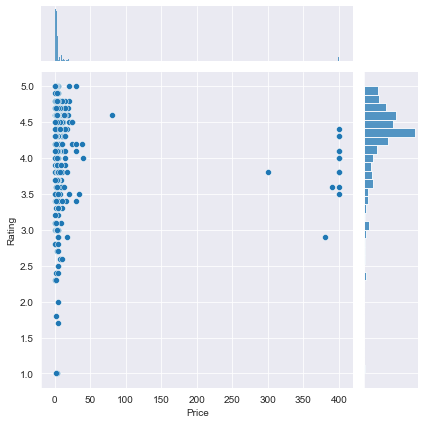

In [91]:
%matplotlib inline
# Веберем строки где рейтинг и размер не равны null
apps_with_size_and_rating_present = apps[apps['Size'].notnull() & apps['Rating'].notnull()]

# Выберем категории, где более 250 приложений
large_categories = apps_with_size_and_rating_present.groupby('Category').filter(lambda x: len(x) >= 250)

# Выведем график зависимости размера и рейтинга
sns.set_style("darkgrid")
plt1 = sns.jointplot(x = large_categories['Size'], y = large_categories['Rating'])

# Выберем приложения, где тип платный
paid_apps = apps_with_size_and_rating_present[apps_with_size_and_rating_present['Type'] == 'Paid']

# Выведем график зависимости цены и рейтинга
plt2 = sns.jointplot(x = paid_apps['Price'], y = paid_apps['Rating'])

# Связь между категорией приложения и ценой приложения

При выборе правильной ценовой стратегии для вашего мобильного приложения необходимо учитывать множество факторов. Важно учитывать готовность вашего клиента платить за ваше приложение. Неправильная цена может нарушить сделку еще до того, как произойдет загрузка. Потенциальных клиентов высокая стоимость может отпугнуть, или они могут удалить приложение, которое они загрузили, получив слишком много рекламы.

In [106]:
# Выберем приложения с ценой выше 200
apps_above_200 = apps[apps['Price'] > 200]
apps_above_200[['Category', 'App', 'Price']]

,Category,App,Price
4197,FAMILY,most expensive app (H),399.99
4362,LIFESTYLE,💎 I'm rich,399.99
4367,LIFESTYLE,I'm Rich - Trump Edition,400.00
5351,LIFESTYLE,I am rich,399.99
5354,FAMILY,I am Rich Plus,399.99
5355,LIFESTYLE,I am rich VIP,299.99
5356,FINANCE,I Am Rich Premium,399.99
5357,LIFESTYLE,I am extremely Rich,379.99
5358,FINANCE,I am Rich!,399.99
5359,FINANCE,I am rich(premium),399.99


Видим, что большинство дорогих программ - это приложения по типу [i am rich](https://en.wikipedia.org/wiki/I_Am_Rich). Следует не рассматривать такие приложения всерьез.

Text(0.5, 1.0, 'App pricing trend across categories')

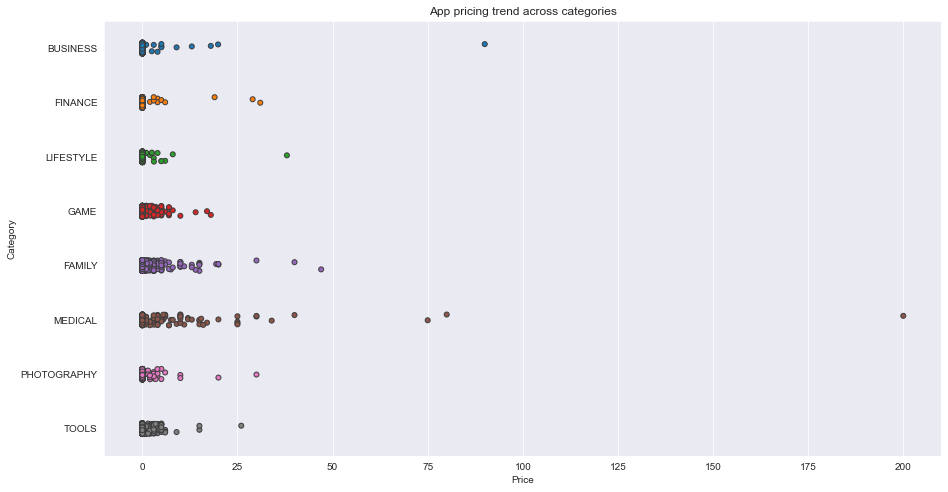

In [107]:
# Выберем несколько популярных категорий
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

apps_below_200 = apps[apps['Price'] <= 200]

popular_app_cats = apps_below_200[apps_below_200.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY',
                                            'MEDICAL', 'TOOLS', 'FINANCE',
                                            'LIFESTYLE','BUSINESS'])]

# Построим график зависимости цены и категории
ax = sns.stripplot(x = popular_app_cats['Price'], y = popular_app_cats['Category'], jitter=True, linewidth=1)
ax.set_title('App pricing trend across categories')

Выше мы видим, что медицинские, финансовые и семейные приложения являются самыми дорогими. Некоторые медицинские приложения доходят даже до 200 долларов! Все игровые приложения по разумной цене ниже 20 долларов.

# Популярность платных приложений по сравнению с бесплатными приложениями

Для приложений в Play Store сегодня существует пять типов стратегий ценообразования: бесплатные, бесплатные, платные, платные и подписка. Давайте сосредоточимся только на бесплатных и платных приложениях. Некоторые характеристики бесплатных приложений таковы:

* Бесплатно скачать.
* Основным источником дохода часто является реклама.
* Часто создается компаниями, у которых есть другие продукты, и приложение служит расширением этих продуктов.
* Может служить инструментом для удержания клиентов, коммуникации и обслуживания клиентов.

Некоторые характеристики платных приложений таковы:

* Пользователям предлагается заплатить один раз за загрузку и использование приложения.
* Пользователь не может по-настоящему прочувствовать приложение перед его покупкой.

Устанавливаются ли платные приложения так же часто, как и бесплатные? Оказывается, что платные приложения имеют относительно меньшее количество установок, чем бесплатные приложения, хотя разница не так велика, как я ожидал!

In [109]:
trace0 = go.Box(
    # Данные для платных приложений
    y = apps[apps['Type'] == 'Paid']['Installs'],
    name = 'Paid'
)

trace1 = go.Box(
    # Данные для бесплатных приложений
    y = apps[apps['Type'] == 'Free']['Installs'],
    name = 'Free'
)

layout = go.Layout(
    title = "Number of downloads of paid apps vs. free apps",
    yaxis = dict(title = "Log number of downloads",
                type = 'log',
                autorange = True)
)

# График
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

# Анализ настроений отзывов пользователей

Отзывы пользователей о приложениях можно проанализировать, чтобы определить, является ли настроение этого приложения положительным, отрицательным или нейтральным. Например, положительные слова в обзоре приложения могут включать такие слова, как "удивительный", "дружелюбный", "хороший", "отличный" и "любовь". Отрицательными словами могут быть такие слова, как "вредоносное ПО", "ненависть", "проблема", "возврат средств" и "некомпетентность".



Text(0.5, 1.0, 'Sentiment Polarity Distribution')

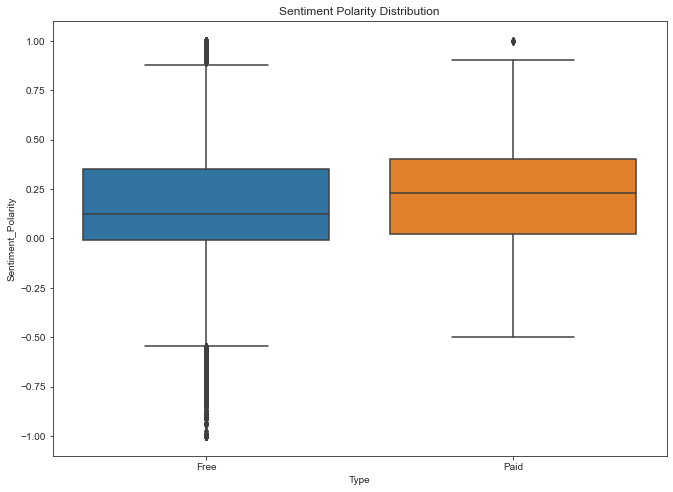

In [115]:
# Load user_reviews.csv
reviews_df = pd.read_csv(r'C:/Users/roald/Desktop/datasets/googleplaystore_user_reviews.csv')

# Join the two dataframes
merged_df = reviews_df.merge(apps, on='App', how='left')

# Drop NA values from Sentiment and Review columns
merged_df = merged_df.dropna(subset = ['Sentiment', 'Translated_Review'])

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

# User review sentiment polarity for paid vs. free apps
ax = sns.boxplot(x = 'Type', y = 'Sentiment_Polarity', data = merged_df)
ax.set_title('Sentiment Polarity Distribution')

Составляя графики настроений и оценок отзывов пользователей о платных и бесплатных приложениях, мы наблюдаем, что бесплатные приложения получают много резких комментариев, о чем свидетельствуют выбросы на отрицательной оси y. Отзывы о платных приложениях никогда не бывают крайне негативными. Это может свидетельствовать о качестве приложений, т. е. о том, что платные приложения в среднем более высокого качества, чем бесплатные. Средний балл полярности для платных приложений немного выше, чем для бесплатных приложений, что согласуется с нашим предыдущим наблюдением.

В этом блокноте мы проанализировали более десяти тысяч приложений из магазина Google Play. Мы можем использовать наши результаты для принятия решений, если когда-нибудь захотим создать приложение самостоятельно.